In [ ]:
# ==============================================
# 1. Montar o Google Drive
# ==============================================
from google.colab import drive
drive.mount('/content/drive')

# ==============================================
# 2. Importações
# ==============================================
import pandas as pd
import numpy as np
import joblib
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_predict
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score,
                             f1_score, matthews_corrcoef, roc_auc_score)
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
import warnings
warnings.filterwarnings('ignore')

# ==============================================
# 3. Leitura do dataset
# ==============================================
OutPath = "/content/drive/MyDrive/Colab Notebooks/5.SINANTB_Nacional_2001-2023/1.4 Resultados e-ou arquivos de saída/"
data = pd.read_csv(os.path.join(OutPath, "Sinantb_desfechos5anosIDH_05-20-2025_00-15-45.csv"))

colunas_remover = ['BENEF_GOV', 'POP_IMIG', 'POP_SAUDE', 'AGRAVOUTRA', 'AGRAVDOENC', 'POP_LIBER',
                   'AGRAVALCOO', 'AGRAVDROGA', 'AGRAVTABAC', 'DT_DIAG', 'DT_INIC_TR', 'year', 'NU_COMU_EX', 'NU_CONTATO', 'idhm_e', 'idhm_l', 'idhm_r', 'TRATAMENTO']
data.drop(columns=colunas_remover, inplace=True)
X = data.drop("DESFECHO", axis=1)
y = data["DESFECHO"]
print(data.columns)

# ==============================================
# 4. Criação única do conjunto de teste balanceado
# ==============================================
np.random.seed(42)
minority_class = y.value_counts().idxmin()
majority_class = y.value_counts().idxmax()
test_size = int(y.value_counts()[minority_class] * 0.2)

minority_indices = np.random.choice(y[y == minority_class].index, test_size, replace=False)
majority_indices = np.random.choice(y[y == majority_class].index, test_size, replace=False)
test_indices = np.concatenate([minority_indices, majority_indices])

X_test_bal = X.loc[test_indices]
y_test_bal = y.loc[test_indices]

X_train_raw = X.drop(test_indices)
y_train_raw = y.drop(test_indices)

# ==============================================
# 5. Modelos e Parâmetros
# ==============================================
modelos = {
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "RandomForest": RandomForestClassifier(random_state=42),
    "GradientBoosting": GradientBoostingClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
}

param_grids = {
    "DecisionTree": {
        'max_depth': [None, 5, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    "RandomForest": {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10]
    },
    "GradientBoosting": {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    },
    "XGBoost": {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5, 7]
    }
}

balanceamentos = {
    "Undersampling": RandomUnderSampler(random_state=42),
    "Oversampling": RandomOverSampler(random_state=42),
    "SMOTE": SMOTE(random_state=42)
}

# ==============================================
# 6. Experimentos
# ==============================================
results_train = []
results_test = []
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for bal_name, balancer in balanceamentos.items():
    X_train_bal, y_train_bal = balancer.fit_resample(X_train_raw, y_train_raw)

    for mod_name, model in modelos.items():
        grid_search = GridSearchCV(model, param_grids[mod_name], cv=cv, scoring='f1_macro', n_jobs=-1)
        grid_search.fit(X_train_bal, y_train_bal)

        print(f"\nMelhores parâmetros para {mod_name} com {bal_name}:")
        print(grid_search.best_params_)
        print(f"Melhor F1-Macro (treino - CV): {grid_search.best_score_:.4f}")

        # Salvar o modelo otimizado após treinamento com GridSearch
        model_path = os.path.join(OutPath, f"{mod_name}_{bal_name}_otimizado.pkl")
        joblib.dump(grid_search.best_estimator_, model_path)
        print(f"Modelo salvo em: {model_path}")

        # Métricas Treino (cross-validation)
        y_train_pred = cross_val_predict(grid_search.best_estimator_, X_train_bal, y_train_bal, cv=cv, method='predict')
        y_train_proba = cross_val_predict(grid_search.best_estimator_, X_train_bal, y_train_bal, cv=cv, method='predict_proba')[:,1]

        cm_train = confusion_matrix(y_train_bal, y_train_pred)
        tn, fp, fn, tp = cm_train.ravel()

        results_train.append({
            'Balanceamento': bal_name,
            'Modelo': mod_name,
            'Accuracy': accuracy_score(y_train_bal, y_train_pred),
            'F1-Score': f1_score(y_train_bal, y_train_pred),
            'F1-Macro': f1_score(y_train_bal, y_train_pred, average='macro'),
            'MCC': matthews_corrcoef(y_train_bal, y_train_pred),
            'Specificity': tn / (tn + fp),
            'Sensitivity': tp / (tp + fn),
            'AUC-ROC': roc_auc_score(y_train_bal, y_train_proba)
        })

        # Métricas Teste
        y_test_pred = grid_search.predict(X_test_bal)
        y_test_proba = grid_search.predict_proba(X_test_bal)[:,1]
        cm_test = confusion_matrix(y_test_bal, y_test_pred)
        tn, fp, fn, tp = cm_test.ravel()

        results_test.append({
            'Balanceamento': bal_name,
            'Modelo': mod_name,
            'Accuracy': accuracy_score(y_test_bal, y_test_pred),
            'F1-Score': f1_score(y_test_bal, y_test_pred),
            'F1-Macro': f1_score(y_test_bal, y_test_pred, average='macro'),
            'MCC': matthews_corrcoef(y_test_bal, y_test_pred),
            'Specificity': tn / (tn + fp),
            'Sensitivity': tp / (tp + fn),
            'AUC-ROC': roc_auc_score(y_test_bal, y_test_proba)
        })

# ==============================================
# 7. Tabelas consolidadas
# ==============================================
def highlight_max(s):
    return ['font-weight: bold' if v == s.max() else '' for v in s]

df_results_train = pd.DataFrame(results_train)
df_results_test = pd.DataFrame(results_test)

print("\nTabela de Resultados - Treino:")
display(df_results_train.style.apply(highlight_max, subset=df_results_train.columns[2:]))

print("\nTabela de Resultados - Teste:")
display(df_results_test.style.apply(highlight_max, subset=df_results_test.columns[2:]))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Index(['ID_MUNICIP', 'CS_SEXO', 'CS_RACA', 'CS_ESCOL_N', 'AGRAVDIABE', 'HIV',
       'POP_RUA', 'REGIAO', 'IDADE', 'PROP_CONTATOS_EXAMINADOS',
       'DIAS_ATE_INICIO_TRATAMENTO', 'DESFECHO', 'idhm'],
      dtype='object')

Melhores parâmetros para DecisionTree com Undersampling:
{'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2}
Melhor F1-Macro (treino - CV): 0.6090
Modelo salvo em: /content/drive/MyDrive/Colab Notebooks/5.SINANTB_Nacional_2001-2023/1.4 Resultados e-ou arquivos de saída/DecisionTree_Undersampling_otimizado.pkl

Melhores parâmetros para RandomForest com Undersampling:
{'max_depth': 20, 'min_samples_split': 10, 'n_estimators': 100}
Melhor F1-Macro (treino - CV): 0.6298
Modelo salvo em: /content/drive/MyDrive/Colab Notebooks/5.SINANTB_Nacional_2001-2023/1.4 Resultados e-ou arquivos de saída/RandomForest_Undersampling_otimizado.pkl

,Balanceamento,Modelo,Accuracy,F1-Score,F1-Macro,MCC,Specificity,Sensitivity,AUC-ROC
0,Undersampling,DecisionTree,0.613152,0.647166,0.609524,0.230632,0.516752,0.709553,0.654404
1,Undersampling,RandomForest,0.631162,0.652189,0.629810,0.264264,0.570709,0.691616,0.680174
2,Undersampling,GradientBoosting,0.638555,0.653790,0.637853,0.278189,0.594549,0.682560,0.691083
3,Undersampling,XGBoost,0.639307,0.655693,0.638488,0.279884,0.591714,0.686900,0.691530
4,Oversampling,DecisionTree,0.841102,0.822630,0.839360,0.697503,0.945247,0.736957,0.853231
5,Oversampling,RandomForest,0.882566,0.875999,0.882236,0.769460,0.935522,0.829610,0.949509
6,Oversampling,GradientBoosting,0.701024,0.705052,0.700968,0.402198,0.687369,0.714679,0.771328
7,Oversampling,XGBoost,0.675196,0.686032,0.674809,0.351230,0.640685,0.709708,0.740494
8,SMOTE,DecisionTree,0.744389,0.738392,0.744255,0.489293,0.767312,0.721466,0.751913
9,SMOTE,RandomForest,0.792935,0.796065,0.792887,0.586147,0.777588,0.808283,0.864921



Tabela de Resultados - Teste:


,Balanceamento,Modelo,Accuracy,F1-Score,F1-Macro,MCC,Specificity,Sensitivity,AUC-ROC
0,Undersampling,DecisionTree,0.609838,0.635173,0.607947,0.221826,0.540394,0.679282,0.650600
1,Undersampling,RandomForest,0.627662,0.650933,0.626000,0.257624,0.560995,0.694329,0.676747
2,Undersampling,GradientBoosting,0.633681,0.649812,0.632902,0.268503,0.587616,0.679745,0.686043
3,Undersampling,XGBoost,0.633391,0.650483,0.632512,0.268068,0.584491,0.682292,0.688003
4,Oversampling,DecisionTree,0.555266,0.632876,0.534461,0.121970,0.343866,0.766667,0.555273
5,Oversampling,RandomForest,0.582176,0.670981,0.549346,0.195242,0.312269,0.852083,0.634143
6,Oversampling,GradientBoosting,0.633681,0.661316,0.631225,0.270994,0.552083,0.715278,0.681237
7,Oversampling,XGBoost,0.635069,0.659724,0.633144,0.273021,0.562616,0.707523,0.687737
8,SMOTE,DecisionTree,0.551447,0.619022,0.536876,0.110051,0.374074,0.728819,0.551838
9,SMOTE,RandomForest,0.574479,0.656322,0.548898,0.169406,0.336343,0.812616,0.620529


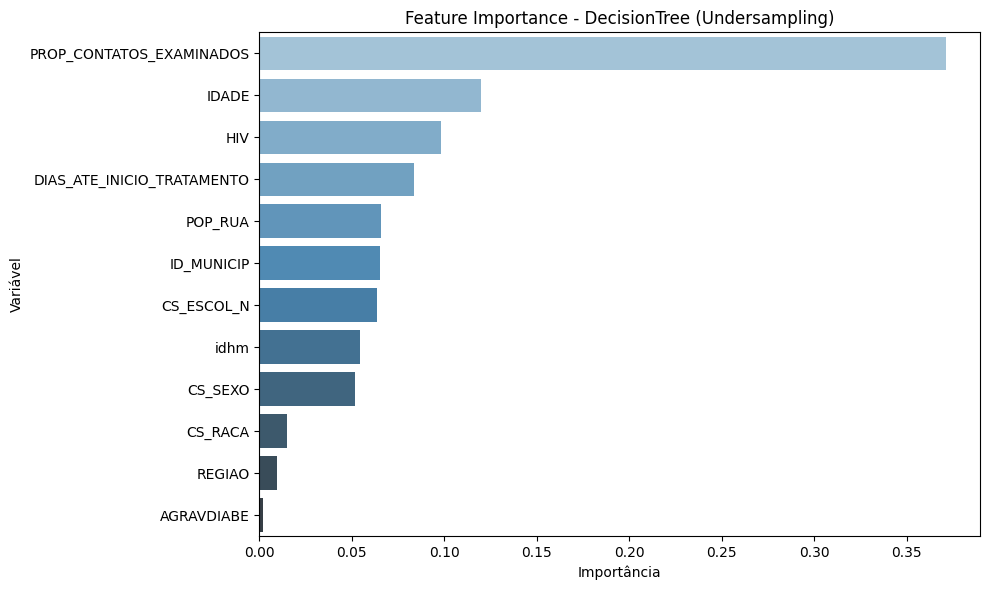

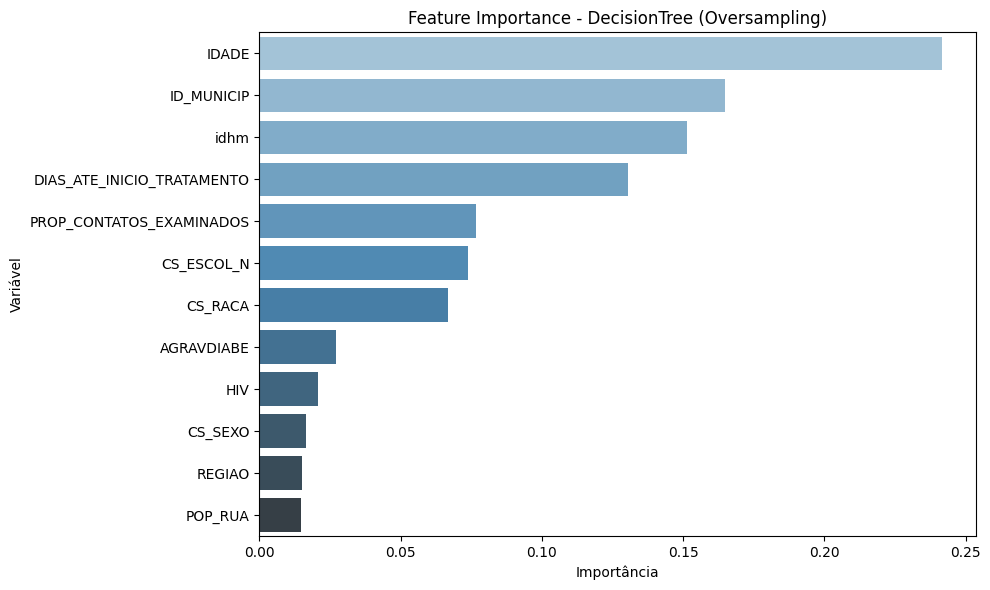

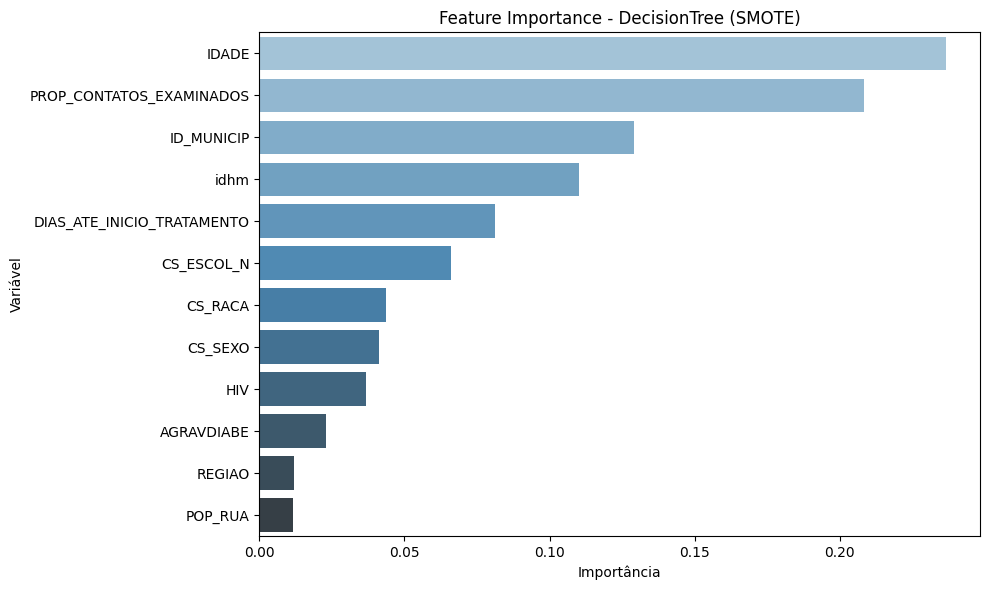

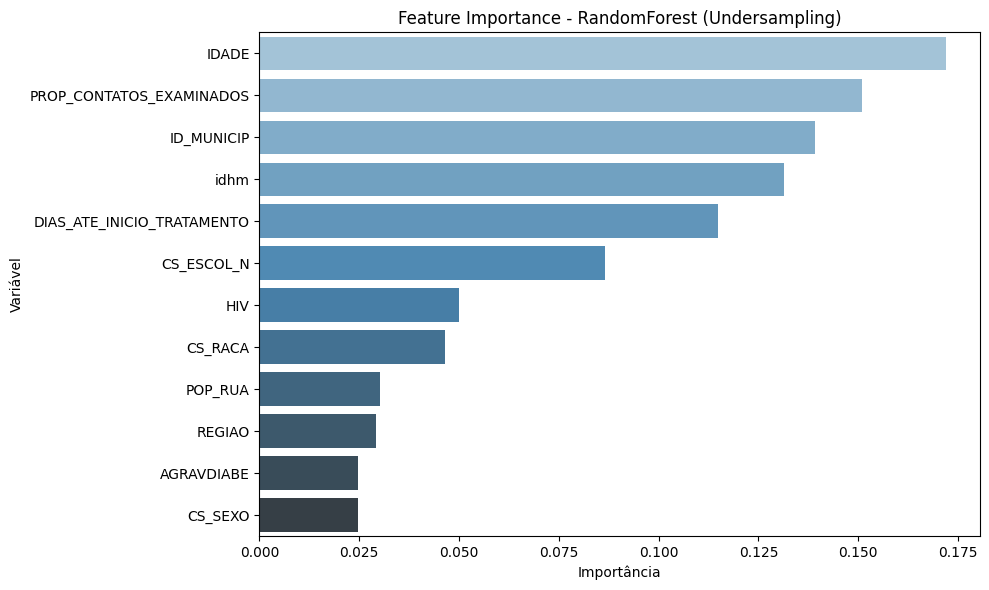

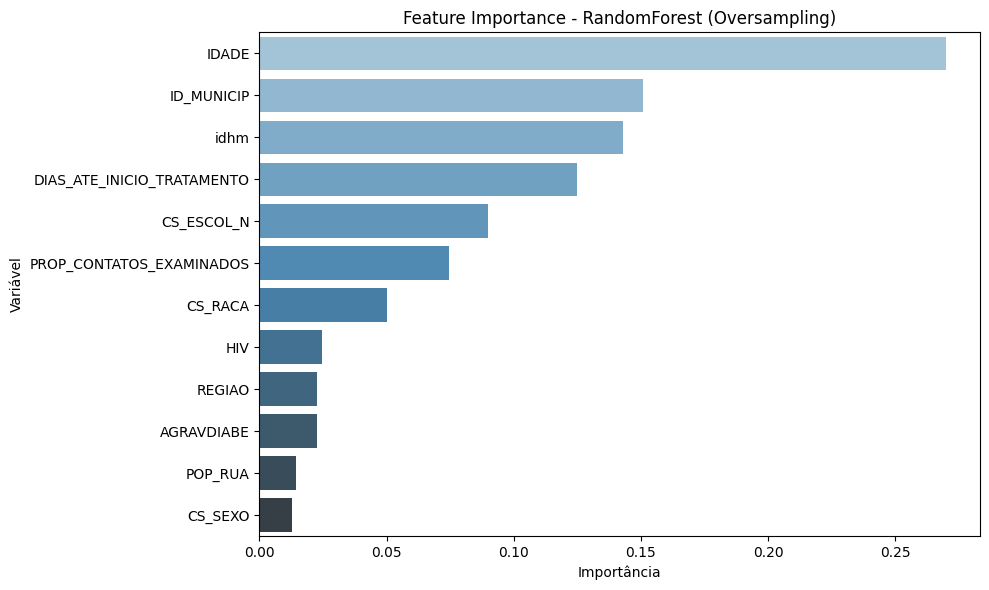

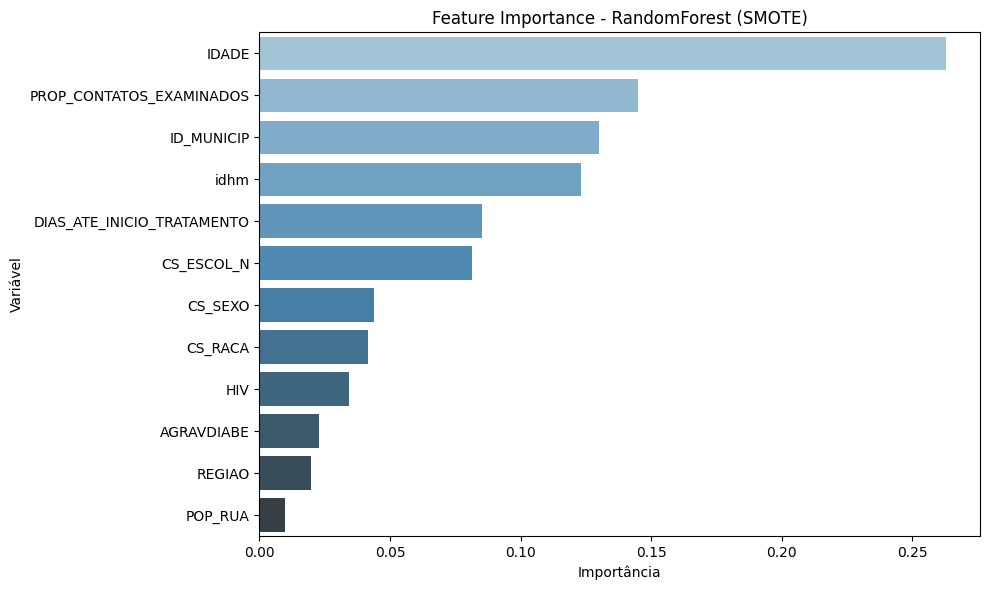

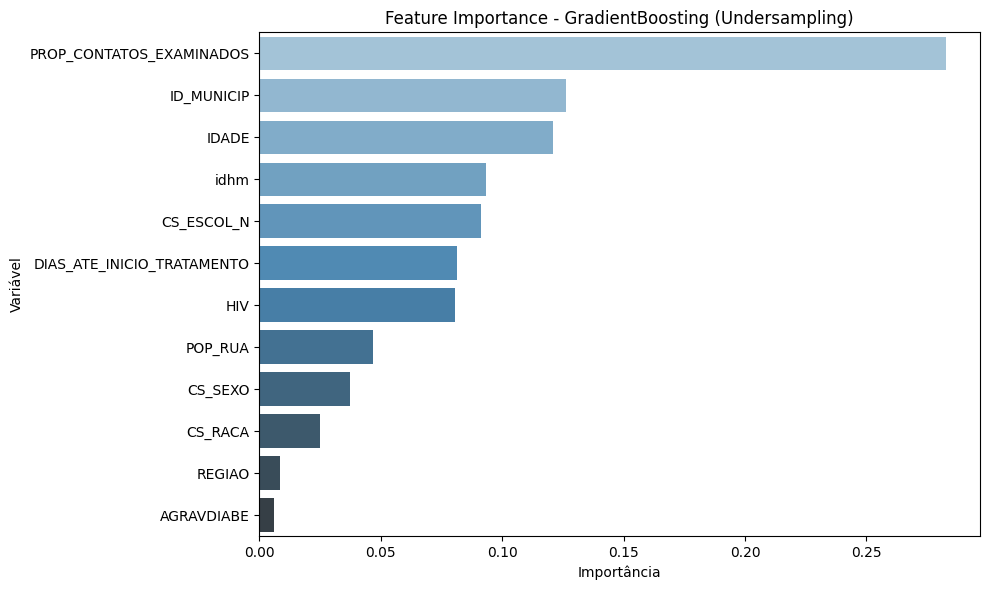

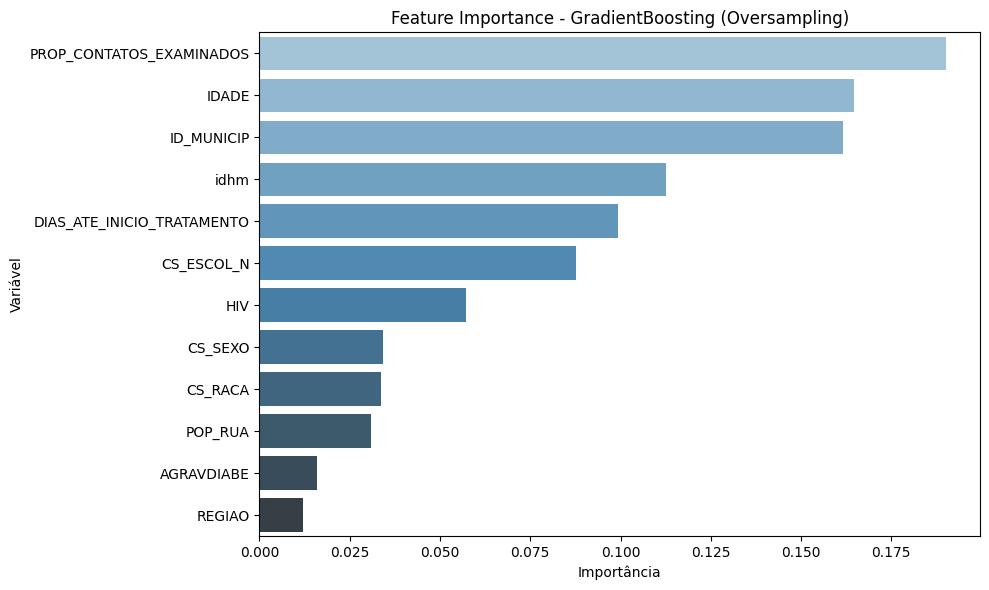

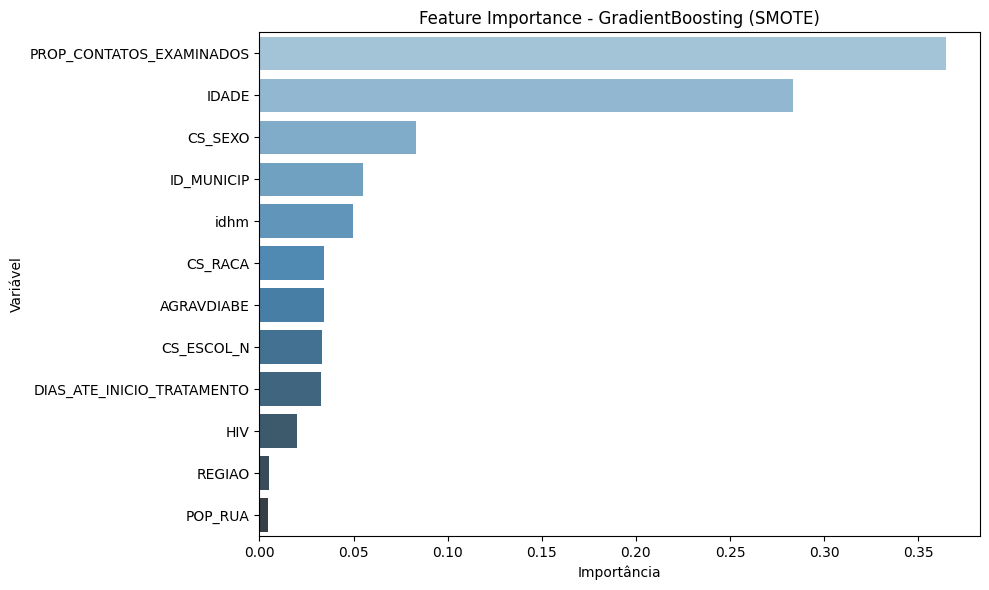

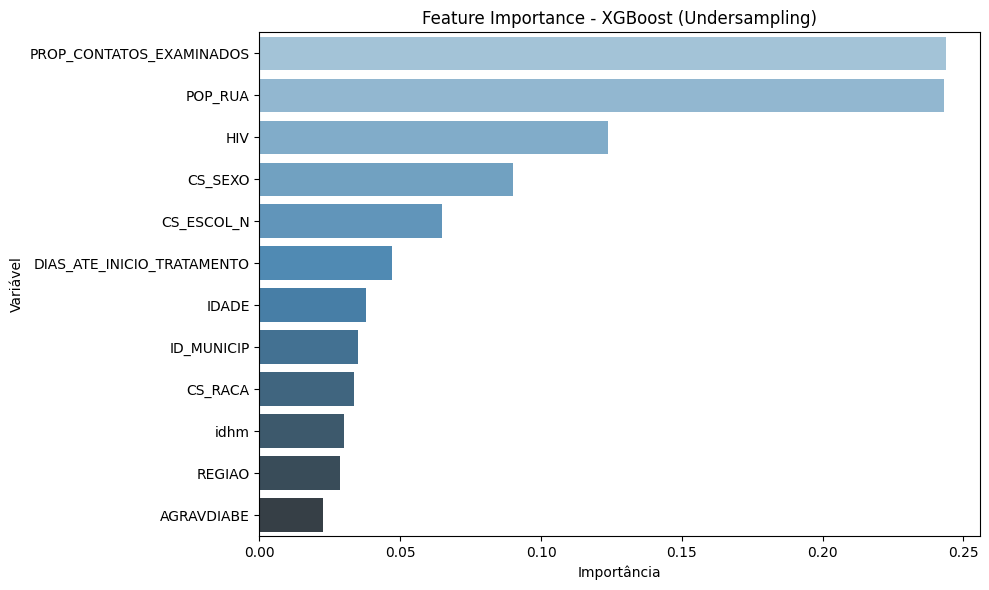

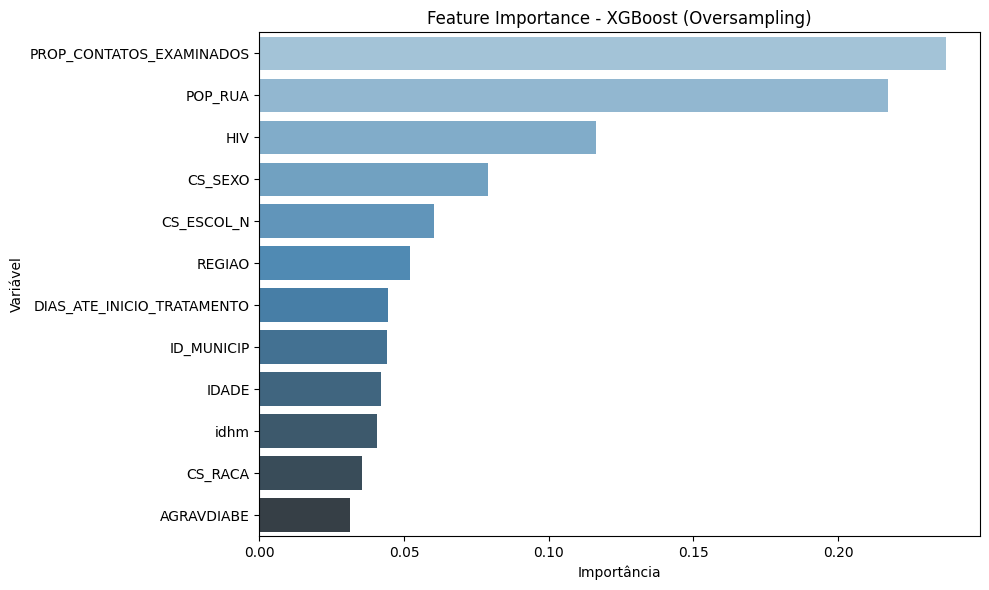

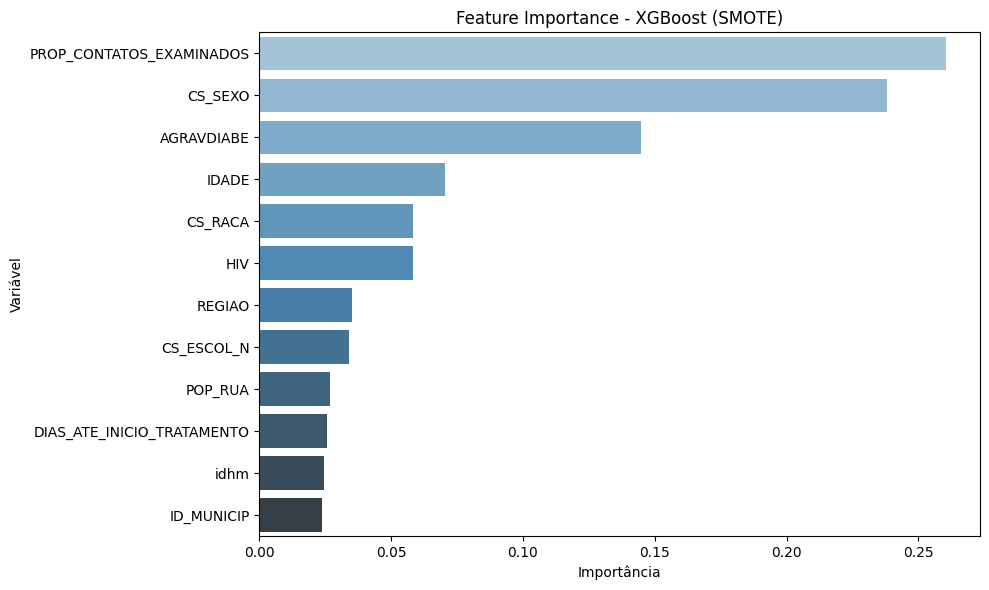

In [ ]:
# =============================
# Importações necessárias
# =============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

# =============================
# Caminho onde os modelos estão salvos
# =============================
OutPath = "/content/drive/MyDrive/Colab Notebooks/5.SINANTB_Nacional_2001-2023/1.4 Resultados e-ou arquivos de saída/"

# Lista dos modelos e balanceamentos
modelos = ["DecisionTree", "RandomForest", "GradientBoosting", "XGBoost"]
balanceamentos = ["Undersampling", "Oversampling", "SMOTE"]

# =============================
# Carregamento e Feature Importance
# =============================
for modelo in modelos:
    for bal in balanceamentos:
        nome_modelo = f"{modelo}_{bal}_otimizado.pkl"
        caminho_modelo = os.path.join(OutPath, nome_modelo)

        if os.path.exists(caminho_modelo):
            clf = joblib.load(caminho_modelo)

            # Obter as importâncias das features
            if hasattr(clf, 'feature_importances_'):
                importancias = clf.feature_importances_
                indices = np.argsort(importancias)[::-1]

                # Nomes das features
                features = X.columns

                # Plotar gráfico
                plt.figure(figsize=(10, 6))
                sns.barplot(x=importancias[indices], y=features[indices], palette="Blues_d")
                plt.title(f"Feature Importance - {modelo} ({bal})")
                plt.xlabel('Importância')
                plt.ylabel('Variável')
                plt.tight_layout()
                plt.show()

            else:
                print(f"O modelo {modelo} ({bal}) não tem feature_importances_.")
        else:
            print(f"Modelo não encontrado: {caminho_modelo}")


In [6]:
# ==============================================
# Experimento: Combinações entre Grupos + 5 Runs
# Métricas: Accuracy, F1-Score, F1-Macro, MCC, Specificity, Sensitivity, AUC-ROC
# ==============================================

# 1. Montar Drive no Colab (opcional)
try:
    from google.colab import drive
    drive.mount('/content/drive')
    print("Drive montado no Colab.")
except ModuleNotFoundError:
    print("Rodando localmente; pulando montagem do Drive.")

# Instalar dependências em Colab
try:
    get_ipython().system('pip install --quiet tabpfn imbalanced-learn xgboost')
except:
    pass

# 2. Importações
import os
import pandas as pd
import numpy as np
import torch
import pickle
from tabpfn import TabPFNClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, matthews_corrcoef,
    confusion_matrix, roc_auc_score
)

print("Imports concluídos.")

# 3. Carregar e preparar dados
OutPath = "/content/drive/MyDrive/Colab Notebooks/5.SINANTB_Nacional_2001-2023/1.4 Resultados e-ou arquivos de saída"
file_name = "Sinantb_desfechos5anosIDH_05-20-2025_00-15-45.csv"
data = pd.read_csv(os.path.join(OutPath, file_name))
data.drop(columns=['DT_DIAG','DT_INIC_TR','TRATAMENTO'], inplace=True)
print(f"Dados carregados: {data.shape}")

# 4. Separar X e y e criar teste balanceado
X = data.drop("DESFECHO", axis=1)
y = data["DESFECHO"]
np.random.seed(42)
min_cls, maj_cls = y.value_counts().idxmin(), y.value_counts().idxmax()
n_test = int(y.value_counts()[min_cls] * 0.2)
min_idx = np.random.choice(y[y==min_cls].index, n_test, replace=False)
maj_idx = np.random.choice(y[y==maj_cls].index, n_test, replace=False)
test_idx = np.concatenate([min_idx, maj_idx])
X_test, y_test = X.loc[test_idx], y.loc[test_idx]
X_train, y_train = X.drop(test_idx), y.drop(test_idx)
print(f"Teste balanceado: {n_test} de cada classe.")

# 5. Definir grupos e suas combinações pares
groups = {
    "Basico":   ['CS_SEXO','CS_RACA','IDADE'],
    "Clinico":  ['CS_SEXO','CS_RACA','IDADE','HIV','AGRAVDIABE',
                 'AGRAVALCOO','AGRAVDROGA','AGRAVTABAC','AGRAVOUTRA','AGRAVDOENC'],
    "Contatos": ['CS_SEXO','CS_RACA','IDADE','HIV','AGRAVDIABE',
                 'AGRAVALCOO','AGRAVDROGA','AGRAVTABAC','AGRAVOUTRA','AGRAVDOENC',
                 'PROP_CONTATOS_EXAMINADOS','DIAS_ATE_INICIO_TRATAMENTO',
                 'NU_COMU_EX','NU_CONTATO']
}
# pares
combos = {}
for g1, feats1 in groups.items():
    combos[g1] = feats1
for g1 in groups:
    for g2 in groups:
        if g1 < g2:
            combos[f"{g1}+{g2}"] = groups[g1] + [f for f in groups[g2] if f not in groups[g1]]

print(f"Combinações a testar: {list(combos.keys())}")

# 6. Preparar registros
train_records = []
test_records = []
samples_idx = {}

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Dispositivo: {device}")

# 7. Loop por combinação e 100 runs
for name, feats in combos.items():
    print(f"\n### Testando grupo: {name}")
    X_tr = X_train[feats]; X_te = X_test[feats]
    samples_idx[name] = {}
    for run in range(1,101):
        print(f" Run {run}/100")
        maj_ids = y_train[y_train==maj_cls].sample(5000, random_state=run).index
        min_ids = y_train[y_train==min_cls].sample(5000, random_state=run).index
        sel = maj_ids.union(min_ids)
        samples_idx[name][run] = sel
        X_red, y_red = X_tr.loc[sel], y_train.loc[sel]

        clf = TabPFNClassifier(device=device)
        clf.fit(X_red.values, y_red.values)

        # métricas treino
        y_pred_tr = clf.predict(X_red.values)
        y_proba_tr = clf.predict_proba(X_red.values)[:,1]
        tn,fp,fn,tp = confusion_matrix(y_red, y_pred_tr).ravel()
        train_records.append({
            'Combination': name, 'Run': run,
            'Accuracy': accuracy_score(y_red, y_pred_tr),
            'F1-Score': f1_score(y_red, y_pred_tr),
            'F1-Macro': f1_score(y_red, y_pred_tr, average='macro'),
            'MCC': matthews_corrcoef(y_red, y_pred_tr),
            'Specificity': tn/(tn+fp),
            'Sensitivity': tp/(tp+fn),
            'AUC-ROC': roc_auc_score(y_red, y_proba_tr)
        })

        # métricas teste
        y_pred_te = clf.predict(X_te.values)
        y_proba_te = clf.predict_proba(X_te.values)[:,1]
        tn,fp,fn,tp = confusion_matrix(y_test, y_pred_te).ravel()
        test_records.append({
            'Combination': name, 'Run': run,
            'Accuracy': accuracy_score(y_test, y_pred_te),
            'F1-Score': f1_score(y_test, y_pred_te),
            'F1-Macro': f1_score(y_test, y_pred_te, average='macro'),
            'MCC': matthews_corrcoef(y_test, y_pred_te),
            'Specificity': tn/(tn+fp),
            'Sensitivity': tp/(tp+fn),
            'AUC-ROC': roc_auc_score(y_test, y_proba_te)
        })

print("\nExperimentos concluídos.")

# 8. Criar DataFrames
df_train = pd.DataFrame(train_records)
df_test  = pd.DataFrame(test_records)

print("\nTabela de Treino:")
display(df_train)
print("\nTabela de Teste:")
display(df_test)

# 9. Identificar e mostrar melhor combinação e métricas
best_idx = df_test['AUC-ROC'].idxmax()
best = df_test.loc[best_idx]
print(f"\nMelhor combinação: {best['Combination']}")
print("Atributos testados:", combos[best['Combination']])
print("Métricas de Teste:")
for m in ['Accuracy','F1-Score','F1-Macro','MCC','Specificity','Sensitivity','AUC-ROC']:
    print(f"  {m}: {best[m]:.4f}")

# 10. Salvar resultados e artefatos
df_train.to_csv(os.path.join(OutPath,"results_train.csv"), index=False)
df_test.to_csv(os.path.join(OutPath, "results_test.csv"), index=False)

# dataset e modelo da melhor combinação+run
sel_ids = samples_idx[best['Combination']][best['Run']]
df_best = data.loc[sel_ids, combos[best['Combination']]+['DESFECHO']]
df_best.to_csv(os.path.join(OutPath,"best_dataset.csv"), index=False)

clf_best = TabPFNClassifier(device=device)
Xb = X_train[combos[best['Combination']]].loc[sel_ids]
yb = y_train.loc[sel_ids]
clf_best.fit(Xb.values, yb.values)
with open(os.path.join(OutPath,"best_model.pkl"),"wb") as f:
    pickle.dump(clf_best, f)

print("\nArtefatos salvos em OutPath.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive montado no Colab.
Imports concluídos.
Dados carregados: (166487, 28)
Teste balanceado: 8640 de cada classe.
Combinações a testar: ['Basico', 'Clinico', 'Contatos', 'Basico+Clinico', 'Basico+Contatos', 'Clinico+Contatos']
Dispositivo: cuda

### Testando grupo: Basico
 Run 1/5
 Run 2/5
 Run 3/5
 Run 4/5
 Run 5/5
 Run 6/5
 Run 7/5
 Run 8/5
 Run 9/5
 Run 10/5
 Run 11/5
 Run 12/5
 Run 13/5
 Run 14/5
 Run 15/5
 Run 16/5
 Run 17/5
 Run 18/5
 Run 19/5
 Run 20/5
 Run 21/5
 Run 22/5
 Run 23/5
 Run 24/5
 Run 25/5
 Run 26/5
 Run 27/5
 Run 28/5
 Run 29/5
 Run 30/5
 Run 31/5
 Run 32/5
 Run 33/5
 Run 34/5
 Run 35/5
 Run 36/5
 Run 37/5
 Run 38/5
 Run 39/5
 Run 40/5
 Run 41/5
 Run 42/5
 Run 43/5
 Run 44/5
 Run 45/5
 Run 46/5
 Run 47/5
 Run 48/5
 Run 49/5
 Run 50/5
 Run 51/5
 Run 52/5
 Run 53/5
 Run 54/5
 Run 55/5
 Run 56/5
 Run 57/5
 Run 58/5
 Run 59/5
 Run 60/5
 Run 61

,Combination,Run,Accuracy,F1-Score,F1-Macro,MCC,Specificity,Sensitivity,AUC-ROC
0,Basico,1,0.5601,0.552811,0.559983,0.120264,0.5764,0.5438,0.576478
1,Basico,2,0.5520,0.552269,0.552000,0.104000,0.5514,0.5526,0.571180
2,Basico,3,0.5464,0.546491,0.546400,0.092800,0.5462,0.5466,0.565297
3,Basico,4,0.5509,0.544292,0.550806,0.101843,0.5654,0.5364,0.570724
4,Basico,5,0.5584,0.563464,0.558341,0.116831,0.5468,0.5700,0.579884
...,...,...,...,...,...,...,...,...,...
595,Clinico+Contatos,96,0.6501,0.666222,0.649282,0.301611,0.6018,0.6984,0.701602
596,Clinico+Contatos,97,0.6491,0.667109,0.648070,0.299961,0.5950,0.7032,0.697201
597,Clinico+Contatos,98,0.6408,0.662152,0.639360,0.283877,0.5776,0.7040,0.696198
598,Clinico+Contatos,99,0.6328,0.652733,0.631586,0.267368,0.5754,0.6902,0.682670



Tabela de Teste:


,Combination,Run,Accuracy,F1-Score,F1-Macro,MCC,Specificity,Sensitivity,AUC-ROC
0,Basico,1,0.554167,0.545915,0.554019,0.108405,0.572338,0.535995,0.571809
1,Basico,2,0.550058,0.547413,0.550042,0.100123,0.555903,0.544213,0.568782
2,Basico,3,0.548380,0.548170,0.548380,0.096759,0.548843,0.547917,0.567420
3,Basico,4,0.545949,0.531750,0.545531,0.092068,0.576273,0.515625,0.567083
4,Basico,5,0.553762,0.561002,0.553640,0.107582,0.537269,0.570255,0.573501
...,...,...,...,...,...,...,...,...,...
595,Clinico+Contatos,96,0.637269,0.654313,0.636385,0.275882,0.587963,0.686574,0.683374
596,Clinico+Contatos,97,0.634606,0.651584,0.633737,0.270501,0.585880,0.683333,0.681189
597,Clinico+Contatos,98,0.635243,0.653738,0.634199,0.272043,0.581829,0.688657,0.682089
598,Clinico+Contatos,99,0.636806,0.655089,0.635782,0.275162,0.583796,0.689815,0.682663



Melhor combinação: Contatos
Atributos testados: ['CS_SEXO', 'CS_RACA', 'IDADE', 'HIV', 'AGRAVDIABE', 'AGRAVALCOO', 'AGRAVDROGA', 'AGRAVTABAC', 'AGRAVOUTRA', 'AGRAVDOENC', 'PROP_CONTATOS_EXAMINADOS', 'DIAS_ATE_INICIO_TRATAMENTO', 'NU_COMU_EX', 'NU_CONTATO']
Métricas de Teste:
  Accuracy: 0.6387
  F1-Score: 0.6579
  F1-Macro: 0.6376
  MCC: 0.2792
  Specificity: 0.5826
  Sensitivity: 0.6948
  AUC-ROC: 0.6859

Artefatos salvos em OutPath.


from matplotlib import pyplot as plt
df_test['Run'].plot(kind='hist', bins=20, title='Run')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_test['Accuracy'].plot(kind='hist', bins=20, title='Accuracy')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_test['F1-Score'].plot(kind='hist', bins=20, title='F1-Score')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_test['F1-Macro'].plot(kind='hist', bins=20, title='F1-Macro')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
df_test.groupby('Combination').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_test.plot(kind='scatter', x='Run', y='Accuracy', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_test.plot(kind='scatter', x='Accuracy', y='F1-Score', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_test.plot(kind='scatter', x='F1-Score', y='F1-Macro', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_test.plot(kind='scatter', x='F1-Macro', y='MCC', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_test['Run'].plot(kind='line', figsize=(8, 4), title='Run')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df_test['Accuracy'].plot(kind='line', figsize=(8, 4), title='Accuracy')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df_test['F1-Score'].plot(kind='line', figsize=(8, 4), title='F1-Score')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df_test['F1-Macro'].plot(kind='line', figsize=(8, 4), title='F1-Macro')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(df_test['Combination'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df_test, x='Run', y='Combination', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(df_test['Combination'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df_test, x='Accuracy', y='Combination', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(df_test['Combination'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df_test, x='F1-Score', y='Combination', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(df_test['Combination'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df_test, x='F1-Macro', y='Combination', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [7]:
import os

train_csv_path = os.path.join(OutPath, "results_train_combinacoes.csv")
test_csv_path  = os.path.join(OutPath, "results_test_combinacoes.csv")

df_train.to_csv(train_csv_path, index=False)
df_test.to_csv(test_csv_path,  index=False)

print(f"Tabela de treino salva em: {train_csv_path}")
print(f"Tabela de teste  salva em: {test_csv_path}")


Tabela de treino salva em: /content/drive/MyDrive/Colab Notebooks/5.SINANTB_Nacional_2001-2023/1.4 Resultados e-ou arquivos de saída/results_train_combinacoes.csv
Tabela de teste  salva em: /content/drive/MyDrive/Colab Notebooks/5.SINANTB_Nacional_2001-2023/1.4 Resultados e-ou arquivos de saída/results_test_combinacoes.csv
